# Introduction
This notebook gives an example how we do **model interpretation**.

It is the third one in a series of 5 notebooks. In the last 2 notebooks we have shown how to do EDA (explorative data analysis) and model comparison and selection. The forthcoming 2 notebooks convey how to implement model training in production as well as scoring for new data which closes the loop of all codings you need to implement for a predictive modeling project.

For a better understanding you should have **basic knowledge of predictive modelling**, i.e. know what a logistic regression is or cross-validation, for instance.

As example data source the well known **titanic data set** is chosen (https://www.kaggle.com/c/titanic/data). It is therefore a classification problem with the binary target *survived/not survived*. Even though you cannot compare the titanic case with a real life setting, the following steps pretty much reflect (on a small scale!) how we conduct data analysis in all our predictive modeling projects.

<br><br>
# 0 Initialization (including undersampling)

We start by loading the results from the previous notebook. Central objects we need are the prepared data (including engineered features) and the features character vector (together with the formula we will utilize in the forethcoming fits).

We also load several packages and do some basic settings (data and output locations, parameters for plotting, ...). 
Furthermore the ***0_init.R*** program allocates the important **hmsPM package** with lots of useful functions we highly utilize  in the following. The detailed implementation of these functions is not important for understanding the approach presented here.

Furthermore we already initialze the **parallel processing** with a cluster comprising of all 4 cpus we have available. In real life situations when having much more data and features, it is highly recommended to have more cpus in place. Our preferred approach is to allocate a cloud virtual machine with >= 16 cpus exclusively for the following processing. 

In [1]:
# Load result from exploration
setwd("C:/MY/hmsPM_R/hmsPM/inst/example") 
load(paste0("data/","1_explore.rdata"))

# Load libraries and functions
suppressMessages(source("./code/0_init.R"))

# Adapt some default parameter 
n.sample = 1e3 #sampling rate
metric = "AUC" #metric for peformance comparison

# Initialize parallel processing
cl = makeCluster(as.numeric(Sys.getenv("NUMBER_OF_PROCESSORS")))
registerDoParallel(cl)
#clusterEvalQ(cl, library(hmsPM))
# stopCluster(cl); closeAllConnections() #stop cluster

In the previous notebook we derived that a boosted tree algorithm with the following tuning parameter set shows the best performance. As we are using this parameter set throughout this notebook we centrally define them here.

In [2]:
# Tuning parameter to use (for xgb)
tunepar = expand.grid(nrounds = 2100, eta = c(0.01),
                      max_depth = c(3), min_child_weight = c(10),
                      colsample_bytree = c(0.7), subsample = c(0.7),
                      gamma = 0, alpha = 0, lambda = 1)


<br> **Sampling**  
In the previous notebook we have also derived how many data is sufficient for modeling (see the appropriate "Learing curve" paragraph). The results can be used for the sampling strategy (in case we do not need the full data). At least you can speed up testing your code by some initial data sampling (which you might rewind for the final run).  

In classification problems you often face **unbalanced data**. In such a case the main information lies in the minority class which in turn proposes the well known undersampling strategy (see also *2_modelcomparison_R.ipynb*) we utilize in the following step for deriving the training data (the test data remains as is). It is important to track the **base ratios (or prioris)** for the original and the undersampled data ("b_all" and "b_sample") in order to be able to rescale the final predictions (see also forthcoming explanations). 

Actually for titanic it does not make sense to sample due to the already small number of data records and the mild imbalance of the target. So the following step is just for illustrating purpose.

Be aware that the basic train/test split (i.e. the derivation of the "fold" variable) was done in the notebook *1_explore_R.ipynb* from which we have loaded the results at the beginning.

In [3]:
## Training data
set.seed(999)
# Just take data from train fold (take all but n.sample at most)
c(df.train, b_sample, b_all) %<-% (df %>% filter(fold == "train") %>%
                                            hmsPM::undersample_n(n_max_per_level = n.sample))
summary(df.train$target); b_sample; b_all



## Test data
set.seed(999)
df.test = df %>% filter(fold == "test") #%>% sample_n(min(nrow(.), n.sample)) #ATTENTION: Do not sample in final run!!!


N   Y 
567 350

N         Y 
0.6183206 0.3816794

N         Y 
0.6183206 0.3816794

In our forthcoming processing we **crossvalidate (cv) several results**. For this task we now define the appropriate train and test folds.  

This step needs high attention in order to correctly evaluate the results we will produce. In pratice we often need to do the split of train and test folds time-based. This requires a special cross-validation strategy as the **test fold needs to comprise only future data** (compared to the train fold).  
A somewhat practical approximation to this strategy is to use standard 5-fold sampling but additionally filter the folds by their train and test attribute (where all test data is recorded later than all the train data). Actually this is the only possible strategy e.g. in case you only have 2 years of data and need at least 1 whole year for the predictive performance estimation of test data (as the predictive performance might vary over the months). 

In the following we illustrate this type of cv split but directly override it by a standard 5-fold split as in our titanic case we do not have time related information and therefore also no time-based split. 

In [4]:
## Folds for crossvalidation
set.seed(123)
c(l.train, l.test) %<-% hmsPM::create_folds(nrow(df), df$fold, method = "byfold") #for illustrating purpose
cat("Time based split cv:\n")
cat("******** Train folds ******** \n"); print(map(l.train, ~ summary(df$fold[.])))
cat("******** Test folds ********\n");print(map(l.test, ~ summary(df$fold[.])))

# Override
set.seed(123)
c(l.train, l.test) %<-% hmsPM::create_folds(nrow(df), method = "cv")

Time based split cv:
******** Train folds ******** 
$Fold1.Rep1
train  test 
  734     0 

$Fold2.Rep1
train  test 
  733     0 

$Fold3.Rep1
train  test 
  738     0 

$Fold4.Rep1
train  test 
  728     0 

$Fold5.Rep1
train  test 
  735     0 

******** Test folds ********
$Fold1.Rep1
train  test 
    0    78 

$Fold2.Rep1
train  test 
    0    79 

$Fold3.Rep1
train  test 
    0    85 

$Fold4.Rep1
train  test 
    0    71 

$Fold5.Rep1
train  test 
    0    79 



<br><br>  
# 1 Performance estimation
## 1.1 Do the full fit and predict on test data
We now estimate the performance of our winner algorithm from *2_modelcomparison_R.ipynb*. We also take the tuning parameter derived in this previous notebook even though these parameter are found with the same train/test split which can result in an unhonest estimation of the predictive performance due to a ***selection bias*** as we might have tried lots of parameter settings and decide for the "luckiest" ones. But we decide for this approach for feasibility reasons and against a pure academic approach.  
One important point in the following training is the usage of a **sparse matrix** to keep memory consumption during creation of the design matrix small as which this approach only the real 1s in the 1-hot codings of categorical variables are kept (see also *2_modelcomparison_R.ipynb*).  

More important is the **scaling** step of the predictions. Remind that we have undersampled our training data (but not the test data) in above steps. Therfore we need to rescale the predictions in a way that they correspond to the **original "priori" probability** of the target. This is important to correctly derive performance metrics (like accurracy for instance) which depend on the probability treshold value for assigning the positive class. In fact this rescaling is just a standard scaling by multiplying the probabilities with b_all/b_sample (i.e. original prior probability divided by undersampled prior probabilty) with an additional norming step (which assures that probabilities sum up to 1). Both steps are encapsulated into the *scale_predictions* method of the hmsPM package.  

Be also aware of the small commented snippet which shows how to do a **prediction in parallel** which might boost up processing time in case you have lots of test data.  

We finally list several predictive performance metrics from which the **AUC** might be the most important one. Actually the forthcoming performance plots are much more informative regarding the analysis of the predictive performance.

In [5]:
# Fit
tmp = Sys.time()
m.train = sparse.model.matrix(as.formula(formula), data = df.train[c("target",features)])
fit = train(x         = m.train,
            y         = df.train$target,
            trControl = trainControl(method = "none", returnData = FALSE),
            method    = xgb_custom,
            tuneGrid  = tunepar)
Sys.time() - tmp

# Predict
yhat_test = predict(fit, 
                    sparse.model.matrix(as.formula(formula), df.test[c("target",features)]), 
                    type = "prob") %>%
  hmsPM::scale_predictions(b_sample, b_all) #rescale
# # Scoring in chunks in parallel in case of high memory consumption of xgboost
# l.split = split(df.test[c("target",features)], (1:nrow(df.test)) %/% 1e5)
# yhat_test = foreach(df.split = l.split, .combine = bind_rows, .packages = c("Matrix","xgboost")) %dopar% {
#   predict(fit, sparse.model.matrix(formula, df.split), type = "prob")
# } %>% hmsPM::scale_predictions(b_sample, b_all) #rescale
hmsPM::performance_summary(data.frame(y = df.test$target, yhat = yhat_test))




Time difference of 8.232581 secs

AUC              Weighted_AUC                  Accuracy 
                0.8421625                 0.8421625                 0.7857143 
                    Kappa                   logLoss          Mean_Sensitivity 
                0.5382544                 0.4687827                 0.6733333 
         Mean_Specificity       Mean_Pos_Pred_Value       Mean_Neg_Pred_Value 
                0.8553719                 0.7426471                 0.8085938 
           Mean_Precision               Mean_Recall                   Mean_F1 
                0.7426471                 0.6733333                 0.7062937 
          Mean_Prevalence       Mean_Detection_Rate Mean_Detection_Prevalence 
                0.3826531                 0.2576531                 0.3469388 
   Mean_Balanced_Accuracy 
                0.7643526

We now create some important plots which help us to analyze the predictive performance of our model for the test data. Let me explain each of these plots:  
- **ROC curve:** Here the tpr (true positive rate or sensitivity) is plotted against the fpr (false positive rate or 1-specificity) depending on the probability threshold (overlayed numbers) for assigning the positive class. The area under this curve is the AUC which is the most widely used metric for evaluating the predictive performance of a classification model.  
It also has a nice interpretation which helps to understand its magnitude: "An AUC of 90% means that if the model is randomly presented one instance of the positive class and one of the negative class it can correctly assign the true class in 90% of all cases. Therefore a random model already has as an AUC of 50%". One can see that it is important to correctly **rank the predictions** for a high AUC. It also has the nice property of being independant of the base ratios (of prior probabilities) and is therefore **unaffected by any undersampling**.  
This also means that you can compare different classifiction tasks and get a feeling which AUC you expect. E.g. claim prediction in automobile insurance yields an AUC around 0.7. A rough rule of thumb from our experience can be stated like this: "With an AUC of 60% you have a signal, 70% reflects a prediction, 80% a good prediction, 90% a really good prediction".  
Be aware of the fact that for high values of an AUC it helps to **compare 1-AUC** for differnt models as it better reflects that a AUC of e.g. 99% is 50% better than an AUC of 98% as the number of miss-assignments in above interpretation analogon is 1% compared to 2%.  
We usually plot the AUC curve also for the negative class which is kind of unnecessary as just a mirrored (on the diagonal) curve results; but in case of a multiclass target you would see the benefit.  


- **Confusion matrix:** Here the true classes are plotted agains the predictions and show the correct and incorrect predictions. The according accuracy is printed in the header.  
Keep in mind that always a probability threshold of 0.5 is used to create these numbers (in case of a two-class target) as the most likely class is assigned as prediction. This can lead to a confusion (maybe the second reason for its name) in case of highly unbalanced target data as in such a case it is not uncommon that no prediction for the minority (which is usually the positive) class reaches 50% which results in a zeros in the second column.  
Actually this works as designed and hints to the recommendation of **not using the confusion matrix in case of unbalanced data**. But if the signal is really sharp and the algorithm can find it then the confusion matrix might look reasonable still in case of an unbalanced target.  


- **Distribution plot:** This plot shows the distributions of the predictions splitted be the target class with the red color denoting the level of the target class listed in the header. Again this plot reveals a duplicity which disappears in case of a multi-class target.  
In a perfect world the "red" distribution would totally concentrate on the right side reflecting high probability for the real class.  


- **Calibration:** We said above that the **AUC is a metric which focuses on the correct ranking of the predictions, one can also say it is a measure showing the discriminative power. But one might also need a good calibration** which means that on average the predicted probabilities should equal the real probabilities. This is visualized in the calibration plot for which the predictions are binned and their grouped average is plotted against the true ratio of the positive ckass (in these grouped).  
A perfect calibrated model would show dots only on the grey shaded diagonal.  


- **Gain and Lift curve:** The gain curve (as well as the lift curve) are **popular in marketing deparments**. It can best be explained with an example. If we test e.g. 25% of all our test samples (which are obviously the 25% with the highest prediction for "surviving") whether their real class is the "green" (i.e. survived) we will find around 50% of all survived passengers. As in the test data 42% passengers survived this percentage denotes minimum percentage for which all survivors can be identified. This ideal case is visualized with the dotted line (for all percentages of passengers tested). A random model without any predictive capability would only find 25% in the first case or 42% in the latter, respecitvely, of all survived passengers as shown by the grey diagonal.  
The ratio of my model detection rate by the rate of the random model is called the lift. For above sample this results in a lift of around 50/25 = 2 for 25% tested (or top predicted) cases of the green class.  


- **Precision-Recall plot:** This plot contrasts **two very important metrics for different threshold values** (overlayed numbers). The precision denotes how many of my survivor predictions have really survived. On the other hand the recall shows how many of my survivors I catch with my model predictions and equals the tpr (true positive rate). 
Both metrics are listed as ratios (or probabilities) and obvioulsy depend on the threshold and are kind of **contradicting** in the sense of one metrics decreases if the other increases and vice versa when changing the threshold.  


- **Precision plot:** Additionally just plotting the precision against the percentage of top predictions (or "samples tested" as the label denotes) can reveal the **desired performance metric for lots of prediction problems (instead of the AUC)**. Think of a fraud model which predicts the probability of fraudulent insurance claims.  
Usually, due to the high amount of claims, a company can just check a minor percentage of all claims for being fraudulent. E.g. if just 20% of all claims can be checked the precision curve shows that around 90% of these are fraudulent when taking the red precision curve as a hypthetic precision plot for this example.  
Actually it can happen that you get a real good AUC but a bad precision for the top rated cases as the model is bad just for these cases. Then the ROC curve would start very shallow at the left side (near the diagonal) but gets steeper later resulting in still high area under the ROC curve which might bluff you.  
One final intersting fact: the Precision plot and the Lift plot always have the exact same shape which everyone can derive after some thinking.

[[1]]
NULL


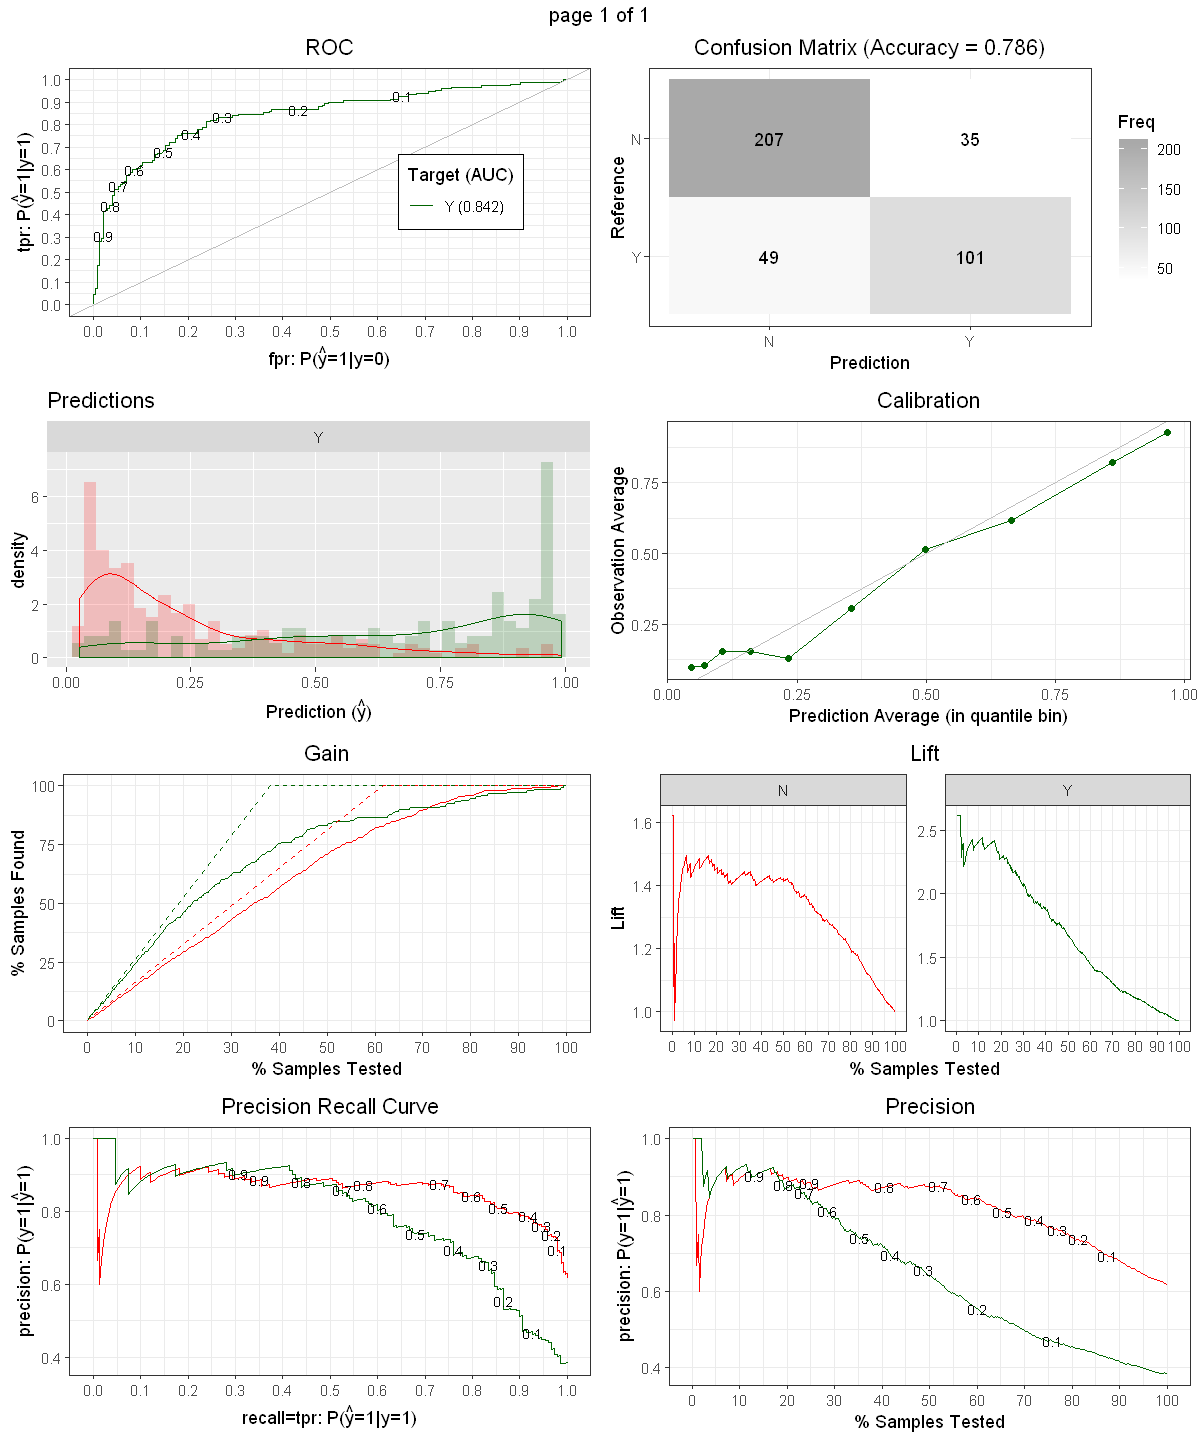

In [6]:
# Plot performance
plots =  hmsPM::plot_all_performances(y        = df.test$target,
                                      yhat     = yhat_test,
                                      colors   = twocol,
                                      ylim     = c(0,1),
                                      oneclass = TRUE)
options(repr.plot.width = 10, repr.plot.height = 12) #adapt this for different resolution
marrangeGrob(suppressMessages(plots), ncol = 2, nrow = 4) #arrange plots

<br>  
## 1.2 Check performance for crossvalidated fits
In order to get a feeling for the robustness of above performance analysis we investitgate the **AUC also for crossvalidated data**. In detail we refit the model on each train fold and evaluate the AUC on each test fold we created above. Below we can see that there is quite some variation of the AUC between 0.84 and 0.9. Again this is mostly due to the limited data we use here in the titanic case.  

Be aware that we receive 5 model fits which we save also for later model interpretation tasks which we also like to crossvalidate. 

In [7]:
## Fit
l.cv = foreach(i = 1:length(l.train), .combine = c,
               .packages = c("caret","ROCR","xgboost","Matrix","dplyr","purrr","zeallot","hmsPM")
) %dopar% {

  # Get cv data (ATTENTION: basically do the same as above for the full run)
  c(df.train_cv, b_sample_cv, b_all_cv) %<-% (df[l.train[[i]],] %>% 
                                                hmsPM::undersample_n(n_max_per_level = n.sample))
  
  df.test_cv = df[l.test[[i]],] #%>% sample_n(min(nrow(.), n.sample)) #ATTENTION: Do not sample in final run!!!

  # Fit and calc performance
  fit_cv = train(x         = sparse.model.matrix(as.formula(formula), df.train_cv),
                 y         = df.train_cv$target,
                 trControl = trainControl(method = "none", returnData = FALSE),
                 method    = xgb_custom,
                 tuneGrid  = tunepar)
  yhat_cv = predict(fit_cv, 
                    sparse.model.matrix(as.formula(formula), df.test_cv), 
                    type = "prob") %>%
    hmsPM::scale_predictions(b_sample_cv, b_all_cv)
  perf_cv = hmsPM::performance_summary(data.frame(yhat = yhat_cv, y = df.test_cv$target))    
  return(setNames(list(fit_cv, perf_cv, b_sample_cv, b_all_cv),
                  c(paste0("fit_",i), paste0("perf_",i), paste0("b_sample_",i), paste0("b_all_",i))))
}

# Print performance
map_dbl(l.cv[grep("perf",names(l.cv))], ~ .[metric])

# Copy for later usage
l.fits = l.cv[grep("fit",names(l.cv))]
l.b_sample = l.cv[grep("b_sample",names(l.cv))]
l.b_all = l.cv[grep("b_all",names(l.cv))]

perf_1    perf_2    perf_3    perf_4    perf_5 
0.8536146 0.8608972 0.8652877 0.8658998 0.8655747

<br>  
## 1.3 Most important variables (importance_cum < 95) model fit
Addtionally we perform another comparison of the predictive performance: Actually we derive the variable importance (explained in more detail in chapter 3, see below) on the training data and use only variables which have **cumulated importance of 95** (of 100). Here this results in a **reduced model** of just 6 features which yields an AUC which is just slightly lower than the one of the full model. It is crucial to define the 95-threshold in advance and, more importantly, derive the **variable importance on the train data** in order to prevent this step from any selection bias.  

This analysis can consult any discussion about possible reduced data retrieval!

Model with just 6 out of 14 features

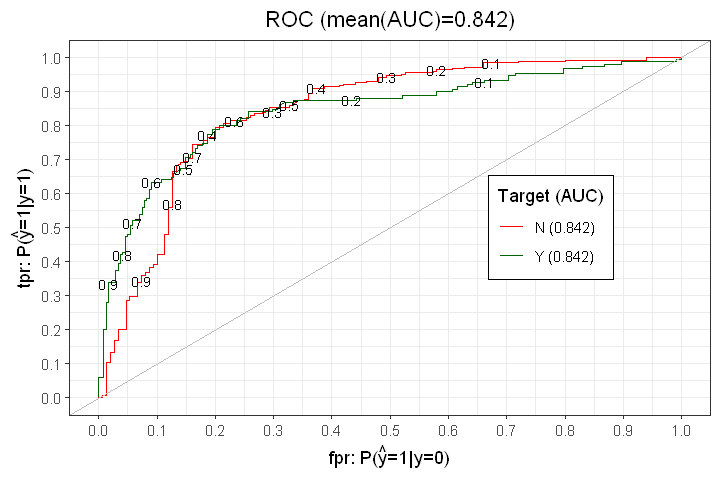

In [8]:
# Variable importance (on train data!)
df.varimp_train = hmsPM::calc_varimp_by_permutation(df_data        = df.train,
                                                    fit            = fit,
                                                    formula_string = formula, sparse = TRUE,
                                                    metric         = "AUC",
                                                    b_sample = b_sample, b_all = b_all)

# Top features (importances sum up to 95% of whole sum)
features_top = df.varimp_train %>% filter(importance_cum < 95) %>% .$feature
formula_top = paste("target", "~ -1 + ", paste(features_top, collapse = " + "))

# Fit again only on features_top
fit_top = train(x         = sparse.model.matrix(as.formula(formula_top), df.train[c("target",features_top)]),
                y         = df.train$target,
                trControl = trainControl(method = "none", returnData = FALSE, allowParallel = FALSE),
                method    = xgb_custom,
                tuneGrid  = tunepar)

# Plot performance
yhat_top = predict(fit_top,
                   sparse.model.matrix(as.formula(formula_top), df.test[c("target",features_top)]),
                   type = "prob") %>%
  hmsPM::scale_predictions(b_sample, b_all)
plots = suppressWarnings(hmsPM::plot_all_performances(y = df.test$target, yhat = yhat_top, colors = twocol))

options(repr.plot.width = 6, repr.plot.height = 4)
cat("Model with just",length(features_top),"out of",length(features),"features")
plots[[1]]

<br><br>
# 2 Diagnosis  
## 2.1 Check residuals
In the following snippet we plot the **residuals against the feature values** in order to investigate whether we have some data segments where our model performs badly. Actually for a classification task with unbalanced target this kind of plot might be a little misleading: Think of a a target with a base ratio of 5% for the minority class. When the predictive performance of our model is relatively bad, most predictions will be around this base ratio, which leads to a full bunch of residuals of -0.05 coming from the true 0-class and some residuals of 0.95 from the 1-class. As we also plot a spline fit through the residual cloud which kind of averages the residuals, it might be helpful to plot the residuals separately for both target classes to get a better impression of the prediction deviations. 

For regression tasks it is also worth to plot the **absoulte residuals** as in such plots the spline fit is not averaged as much as in case of positive and negative residuals.

The plots for metric variables shows a binned scatter plot with a corresponding regression spline fit. At the bottom the distribution of the feature is shown. For the categorical variables the residuals are summarized in a box plot per each level with the red cross denoting the mean (and the bar showing the median respectively). The distribution of the levels are shown on the left in each plot (which also corresponds to the width of the box plots). 

For the titanic case we only see a few severe deviations but just for areas or factor levels with few data which therefore does not represent a real concern.

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.97497 -0.20823 -0.06202 -0.01352  0.13421  0.96941 

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?


[[1]]
NULL


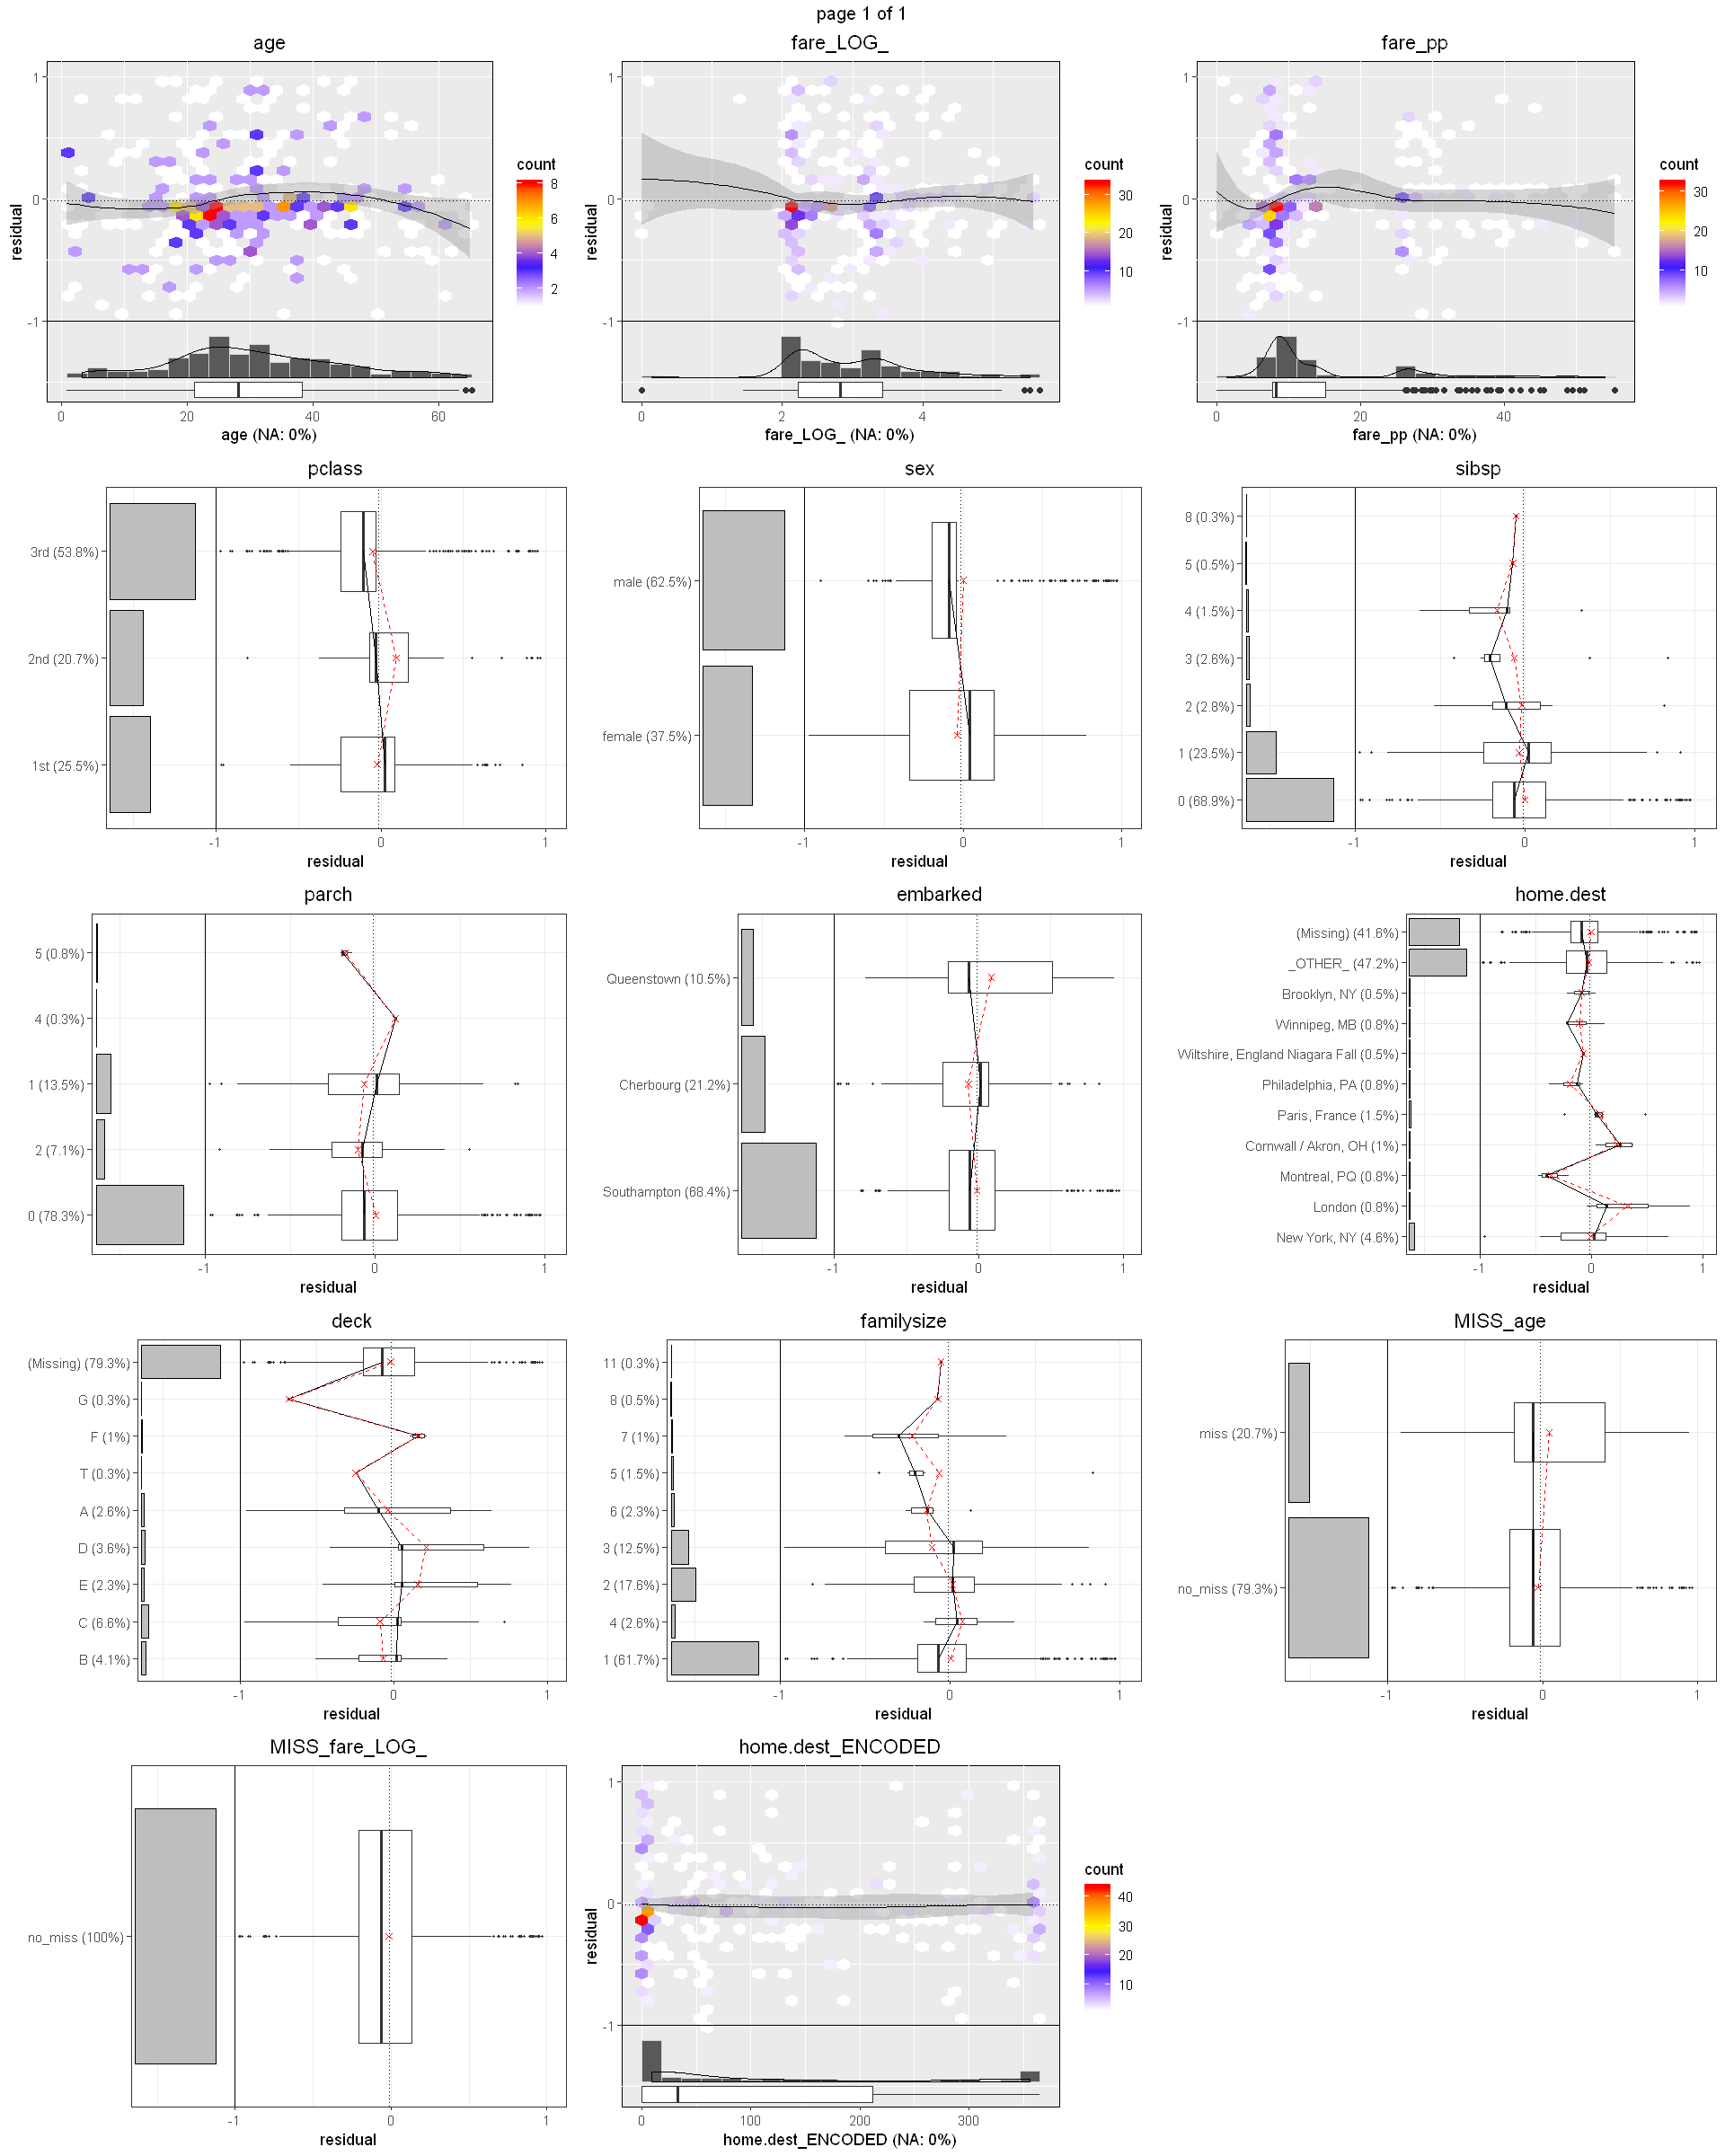

In [9]:
## Residuals
df.test$yhat = yhat_test[,2]
df.test$residual = df.test$target_num - df.test$yhat
summary(df.test$residual)
df.test$abs_residual = abs(df.test$residual)

# For non-regr tasks one might want to plot the following for each target level (df.test %>% filter(target == "level"))
plots = map(features, ~ hmsPM::plot_distr(x            = df.test[[.]],
                                          y            = df.test$residual,
                                          feature_name = .,
                                          target_name  = "residual",
                                          nbins        = 20,
                                          ylim         = c(-1,1),
                                          verbose      = FALSE))
options(repr.plot.width = 16, repr.plot.height = 20) #adapt this for different resolution
marrangeGrob(suppressMessages(plots), ncol = 3, nrow = 5) #arrange plots

<br>  
## 2.2 Explain bad predictions
Boosted trees are **black box models**. Therefore the interpretation of a single prediction is not easy. But some nice model agnostic (i.e. independant of the algorithm used) interpretation approaches exist out there. In our opinion the *shapley values* approch is the most promising one.   

But for the boosted tree a special processing which results in **fully interpretable predictions** is possible! One can parse every split of every tree in the boosted tree ensemble and extract the change in prediction. Then a for a single prediction all these changes can be summed up per feature (used in the splits) which finally returns every feature effect for this prediction. This nicely corresponds to the betas (regression coefficients usually noted as greek beta) in well-known regression models. Be aware that for the boosted tree model the betas for a feature can be different from one single prediction to the other as even the slightest interaction effects are processed by a tree-based algorithm! 

In the following code snippet the whole process of calculating the effects is splitted in several parts: First, all trees are parsed and the splits are stored in a special way in the *df.explainer* data frame. This data frame can subsequently used to explain every prediction which are finally plot in a special way.  

We use this approach here to explain the **10 worst predicitions, i.e. the ones with the biggest residuals**.  

The final plot shows the **ffects in each box which are then transformed to a probabilty by the logit scale** of the vertical axis. This pretty much corresponds to a the well-known logistic regression model interpretation. Only the 8 biggest effects per prediction are shown, all others are summed up to the articial effect "... the rest". So, the inverse logit transformation of the sum of all effects shown in the final black bar gives you the predicted probability ($\hat{y}$). 

For the titanic data nothing really unusual pops up. But for real life cases it often happens that you **overfit regarding just some special features** (see also the explanation for the *learning curve* in the notebook *2_modelcomparison_R.ipynb*) which might pop up here as you would get some unreasonable effects.  

Hold on a second and get aware of the impact: **The predictions of the currently best machine learning algorithm for prediction tasks with tabular data can be fully interpreted in a way which totally corresponds to the classic (logistic) regression.** This is more than gold!


 Predictions and explanations match 


[[1]]
NULL


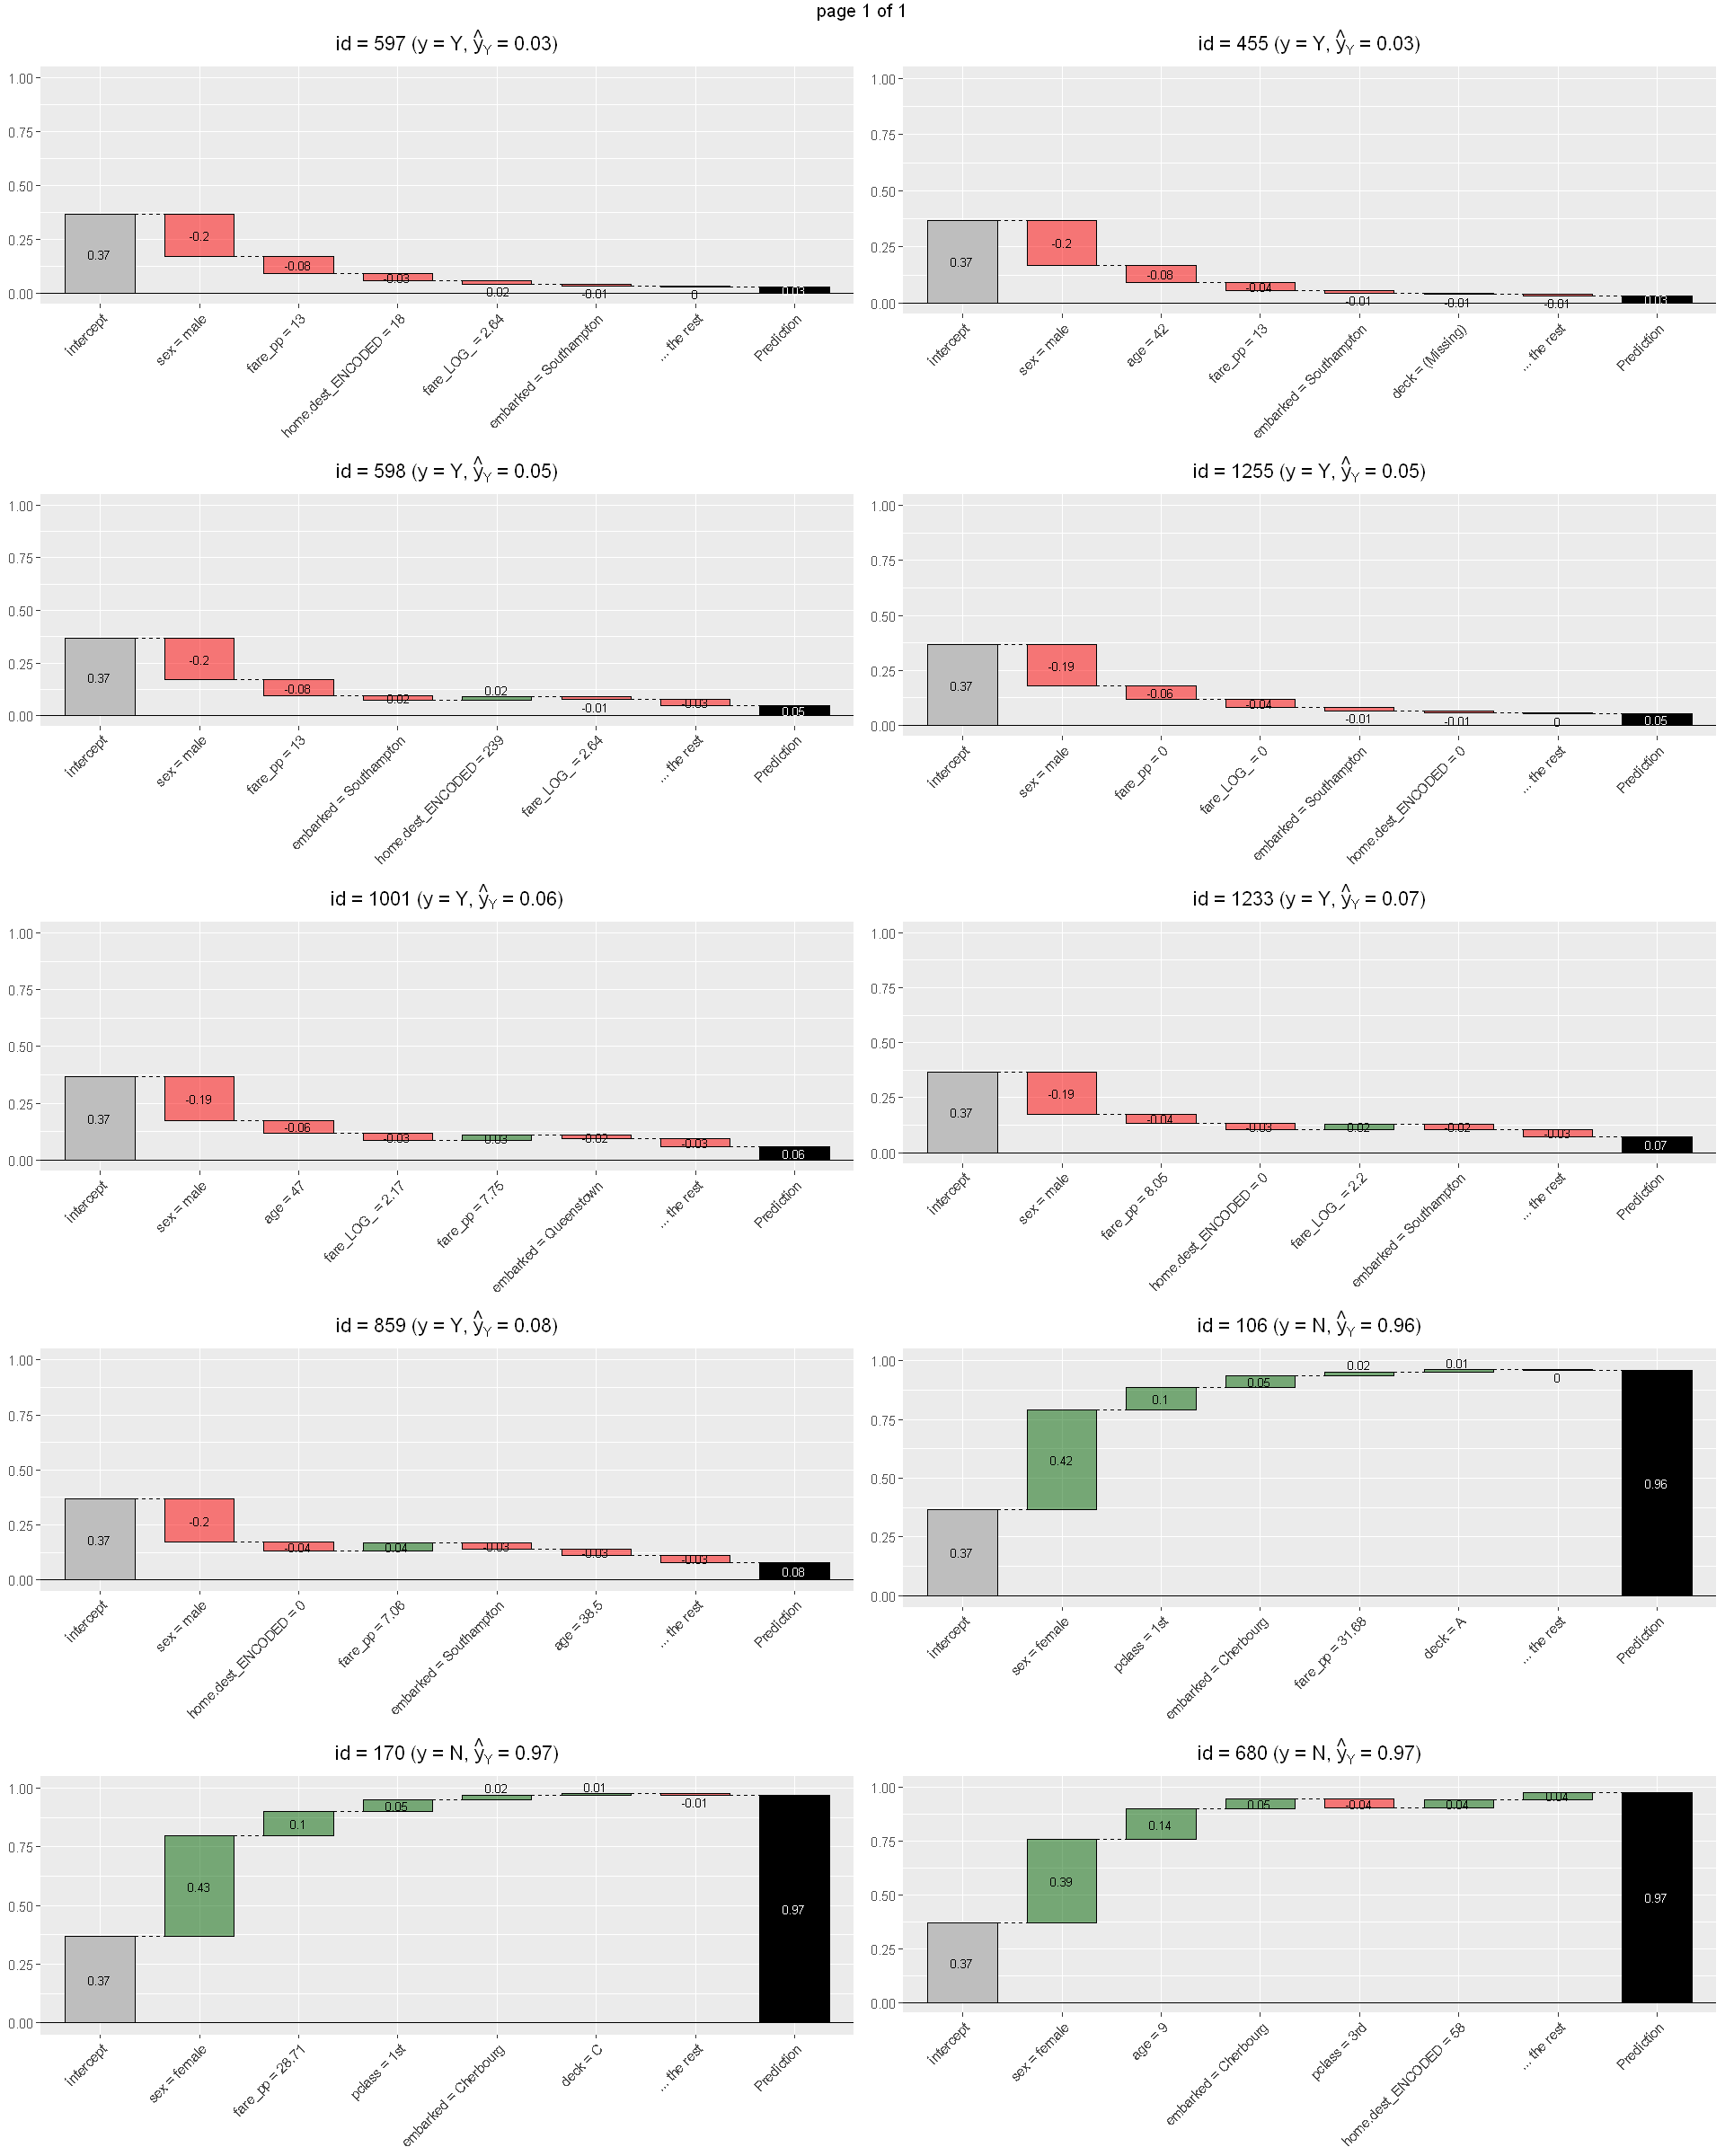

In [10]:
## Get explainer data
df.explainer = hmsPM::calc_xgb_explainer(fit            = fit,
                                         formula_string = formula, sparse = TRUE,
                                         df_train       = df.train)


## Get n_worst most false predicted ids
n_worst = 10
df.test_explain = df.test %>% 
  arrange(desc(residual)) %>% 
  top_n(n_worst, abs_residual)
yhat_explain = predict(fit, 
                       sparse.model.matrix(as.formula(formula), df.test_explain[c("target",features)]), 
                       type = "prob") %>%
  hmsPM::scale_predictions(b_sample, b_all)


## Get explanations
df.explanations = hmsPM::calc_xgb_weights(fit            = fit,
                                          formula_string = formula, sparse = TRUE,
                                          df_test        = df.test_explain,
                                          yhat           = yhat_explain,
                                          df_explainer   = df.explainer,
                                          b_sample = b_sample, b_all = b_all,
                                          id_name = "id",
                                          top_n = 5)

## Plot
plots = plot_all_xgb_explanations(df_explanations = df.explanations,
                                  id_name         = "id",
                                  ylim            = c(0,1),
                                  colors          = alpha(twocol, 0.5),
                                  verbose         = FALSE)
options(repr.plot.width = 16, repr.plot.height = 20) #adapt this for different resolution
marrangeGrob(suppressMessages(plots), ncol = 2, nrow = 5) #arrange plots


<br><br>
# 3 Variable Importance
A typical means for interpreting black box models are **Variable Importance (VI) plots**. There are several different approaches for creating these plots. E.g. for any tree-based algorithm the gain in the internal loss function at each split can be tracked for every training record processed and finally summed up to get a variable importance which is further normed to 100 for the most important feature (i.e. the one which yields biggest improvement). As this can be tracked during training of the model it is a fast way to estimate VI. But it is **model-specific and done on the training data**!  

It would be more helpful to derive the **VI from test data** which better reflects feature importance for prediction. Furthermore a **model-agnostic method**, which does not depend on the algorithm used, is preferred as it can be applied for any algorithm (and allows to compare different algorithm VIs as well). An often used approach is ***VI by feature permutation*** which permutes the values of a feature (to remove any information it comprises apart from its distribution) and calculates the difference in predictive performance to the original data. This is done seperately for each feature. One can imagine that this approach needs lots of ressources due to the many prediction steps. As these can be **easily parallelized** it is important to have a machine with several cores (at least 16 we recommend).

One important goal of the variable importance plots is to show up any main **data leakage**, i.e. information from the future that is highly predictive but cannot be used in a prediction model (see also 1_explore_R.ipynb notebook).

Be aware of the fact that **highly correlated variables share their importance**. So it might be helpful to also consult the correlation plots created in *1_explore_R.ipynb* when discussing the VI plot.

One warning regarding the interpretation of the VI: Basically the **VI is a metric of effect times information** a feature represents. This might lead to a small VI for a feature which has a huge effect but just low variance like a highly unbalanced binary feature. As the huge effect only happens for a small number of records which results in a small VI. One should keep this in mind when consulting the VI plot with the **aim to remove variables**. E.g. think of a questionaire for insurance with a question for risky sports. Even though this has no big influence on the overall predictiver performance as just a few people do risky sports, removing this question from an application form would result in adverse selection as these people could now achive a cheap policy.


<br> 
## 3.1 Default Variable Importance
We first print the default VI plot created by caret (which routes this through to xgboost) to demonstrate one additional disadvantage of the default method which uses the split reduction approach: Each level from a categorical variable gets its own VI due to the 1-hot coding in the design matrix which results in one variable per level when the algorithm recieves the training data.  

Nevertheless **data leakage** features should already pop up here.

In [11]:
varImp(fit)

custom variable importance

  only 20 most important variables shown (out of 60)

                     Overall
sexmale            100.00000
fare_pp             48.05095
fare_LOG_           38.35819
home.dest_ENCODED   32.21775
age                 31.82345
pclass3rd           13.33492
embarkedCherbourg    8.56941
deck(Missing)        7.53636
familysize3          3.26829
parch1               2.41669
sibsp1               2.16861
pclass1st            2.03648
MISS_agemiss         1.59884
pclass2nd            0.98895
home.dest_OTHER_     0.87692
home.dest(Missing)   0.69628
familysize2          0.59656
embarkedQueenstown   0.04482
deckC                0.02747
sibsp2               0.00000

<br>  
## 3.2 Variable Importance by permuation
Now we apply the permutation approach.  

In the plot below we also show the **cumulative importance** which comprises some helpful information in case you plot only a few of lots of features. In such a case the very small VI of many features might falsely lead one to the conclusion that these features are not needed but which in sum might improve the fit to a high extent. 

Again we also crossvalidate the VI to get a better impression of the **robustness of the VIs**. The error bars correspond to a 0.95 distribution interval derived from the cv runs of the VI calculation (with crossvalidated data and fits, assuming normality for the VI values and calculated by +/-1.96 * standard deviation which is a rough approximation indeed). We take the VI dervied from the whole data as best estimate, i.e. the bar height. 

It can be seen that *sex* is always the most important variable. The others show quite high variance in their VI which is again due to the small data amount for titanic (which is more reduced in case of 5-fold cross validation). But even though they are small they account for more than 30% of the whole importance.

[[1]]
NULL


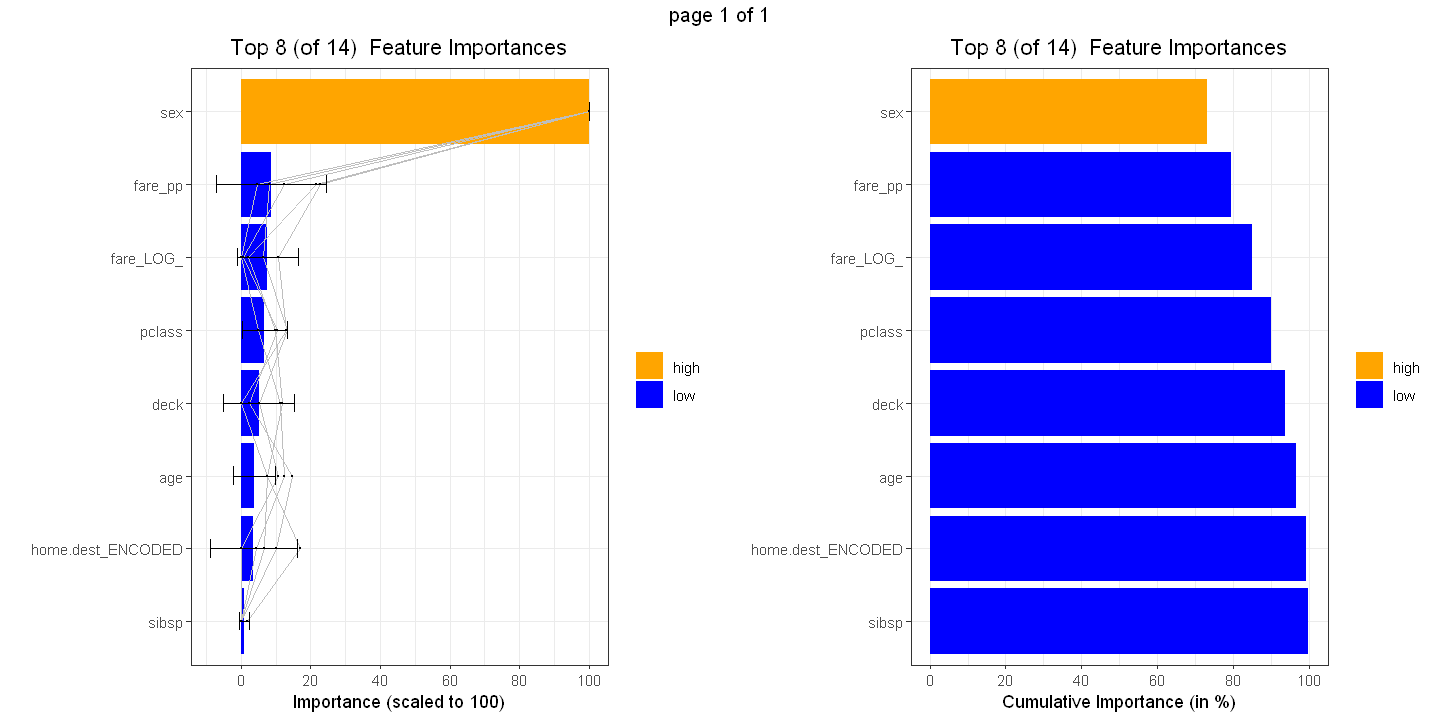

In [12]:
## Importance for "total" fit (on test data!)
df.varimp = hmsPM::calc_varimp_by_permutation(df_data        = df.test,
                                              fit            = fit,
                                              formula_string = formula, sparse = TRUE,
                                              metric         = "AUC",
                                              b_sample = b_sample, b_all = b_all)
topn_features = df.varimp[1:8, "feature"]

# Add other information (e.g. special coloring): color variable is needed -> fill with "dummy" if it should be ommited
df.varimp %<>% mutate(color = cut(x = importance,
                                  breaks = c(-1,10,50,101),
                                  labels = c("low","middle","high")))



## Crossvalidate Importance: ONLY for topn_vars
# Get cv values
df.varimp_cv = c()
for (i in 1:length(l.test)) {
  df.varimp_cv %<>%
    bind_rows(hmsPM::calc_varimp_by_permutation(df_data        = df[l.test[[i]],],
                                                fit            = l.fits[[i]],
                                                formula_string = formula, sparse = TRUE,
                                                metric         = "AUC",
                                                b_sample = l.b_sample[[i]], b_all = l.b_all[[i]]) %>%
                mutate(run = i))
}

# Plot
plots = list(hmsPM::plot_varimp(df_varimp      = df.varimp,
                                n_top_features = 8,
                                df_varimp_cv   = df.varimp_cv),
             hmsPM::plot_varimp_cum(df_varimp      = df.varimp,
                                    n_top_features = 8))
options(repr.plot.width = 12, repr.plot.height = 6) #adapt this for different resolution
marrangeGrob(plots, ncol = 2, nrow = 1)

## 3.3 Compare variable importance for train and test
Now we utilize the VI for training data we already created in 1.3 by comparing them with the VI created for test data. Both are based on the permutation argument. The idea behind this comparison is to identify features which are **prone to overfitting** and therefore have a higher VI for training than for test data. This mostly happens in cases where the generalization gap is high (see *2_modelcomparison_R.ipynb*). 

The comparison can be blurred by the scaling of the most important feature to 100 which influcenced the visual impact. Therefore we also plot VI where the sum of all VIs is normed to 100.  

Any variable showing a highly different VI in the plots is a candidate for an "overfitting feature". Keep in mind that features with low information (see explanation above) will not pop up. The latter could only be identified in partial dependance plot (see chapter 4) showing some weird effects. 

[[1]]
NULL


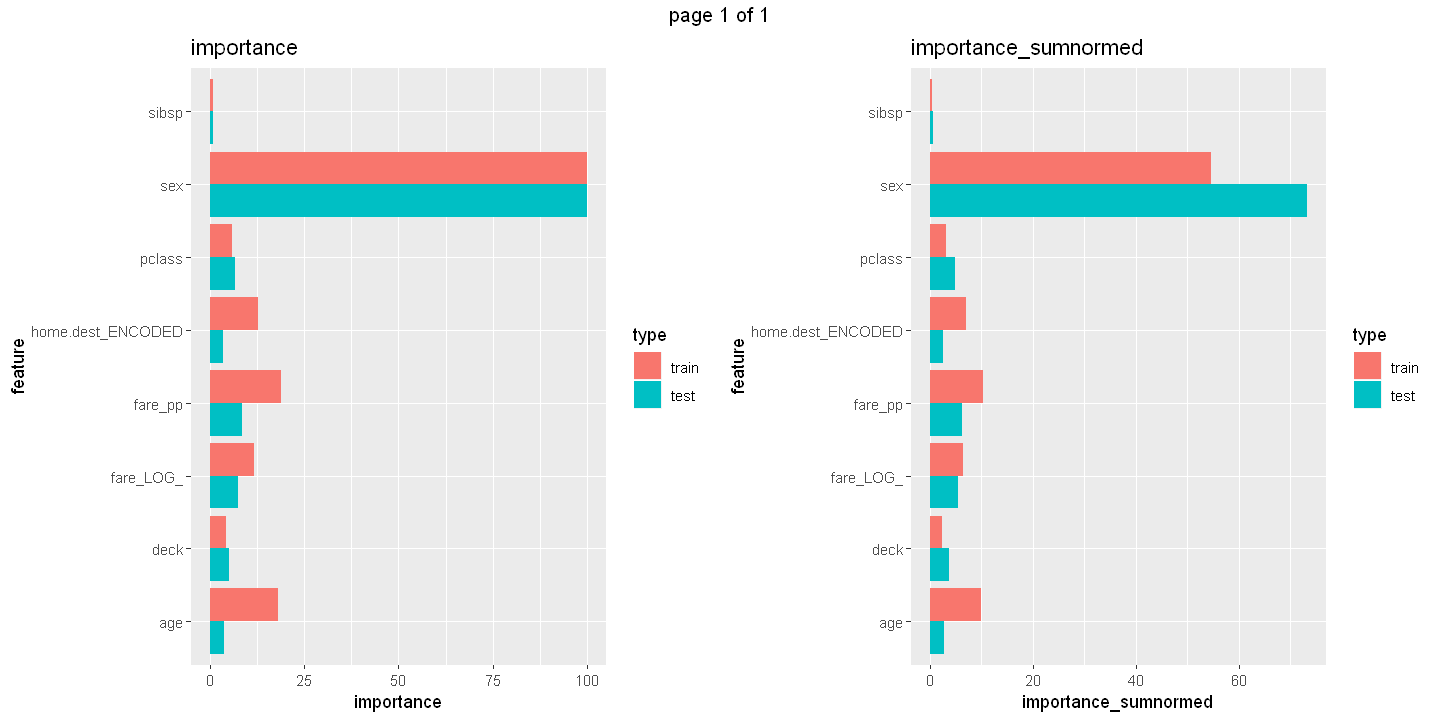

In [13]:
plots = map(c("importance","importance_sumnormed"), ~ {
  df.tmp = df.varimp %>% 
    select_at(c("feature",.x)) %>% 
    mutate(type = "test") %>%
    bind_rows(df.varimp_train %>% 
                select_at(c("feature",.x)) %>% 
                mutate(type = "train")) %>%
    filter(feature %in% topn_features)
  ggplot(df.tmp, aes_string("feature", .x)) +
    geom_bar(aes(fill = type), 
             position = "dodge", 
             stat = "identity") +
    scale_fill_discrete(limits = c("train","test")) +
    coord_flip() +
    labs(title = .x)
})
options(repr.plot.width = 12, repr.plot.height = 6) #adapt this for different resolution
marrangeGrob(plots, ncol = 2, nrow = 1)

<br><br>
# 4 Partial Dependence

Importance plots do not show the shape of the influence of the covariate (e.g. the effect to the categories of a nominal covariate). For this requirement Partial Dependence plots are invented, which can be applied to any black box algorithm.  Partial Dependence Plots show a **univariate projection of the predictors influence adjusted (!) for all other covariates**.  
This influence for one value of a feature is estimated by overwriting the feature in every record with this value, predict the target and average these predictions. For metric features a subset of values is taken where the depedency is evaluated; usually some quantiles are taken. Be aware that this is even more ressource intensive than the variable importance processing even though it is possible to sample down the data for the partial dependence plot. And the processing is easily parallelizable.

One disadvantage is that the marginal distribution of the features is applied by this approach. An extreme example represents a model with the binary feature "pregnant = Yes/No" where both levels would also be evaluated for any male customer to estimate the effect of the sex variable. An alternative approach which circumvent this obstacle represent **ALE (accumulated local effects) plots** (not presented here).  

Furthermore one only sees the average effect. Individual effects might be total different due to any interaction effects which are modeled with trees. **ICE (individual conditional effects) plots** are an alternative, here a sample of partial dependencies of single records are overlayed (which result in the partial dependence when averaged).

So partial dependence plots represent a **simplification to the real effect** but can be interpreted like (averaged) betas of a classic regression model.

It is also possible to plot **bivariate partial dependencies** of 2 variables together which would also show interaction effects (like "the effect of age is different for male and female").

In the following snippet we also crossvalidate the partial dependence plot in order to get a feeling for effects and noise. This is done similarly to the variabl importance (see above), i.e. the error ars are calculted in the same way.  


[[1]]
NULL


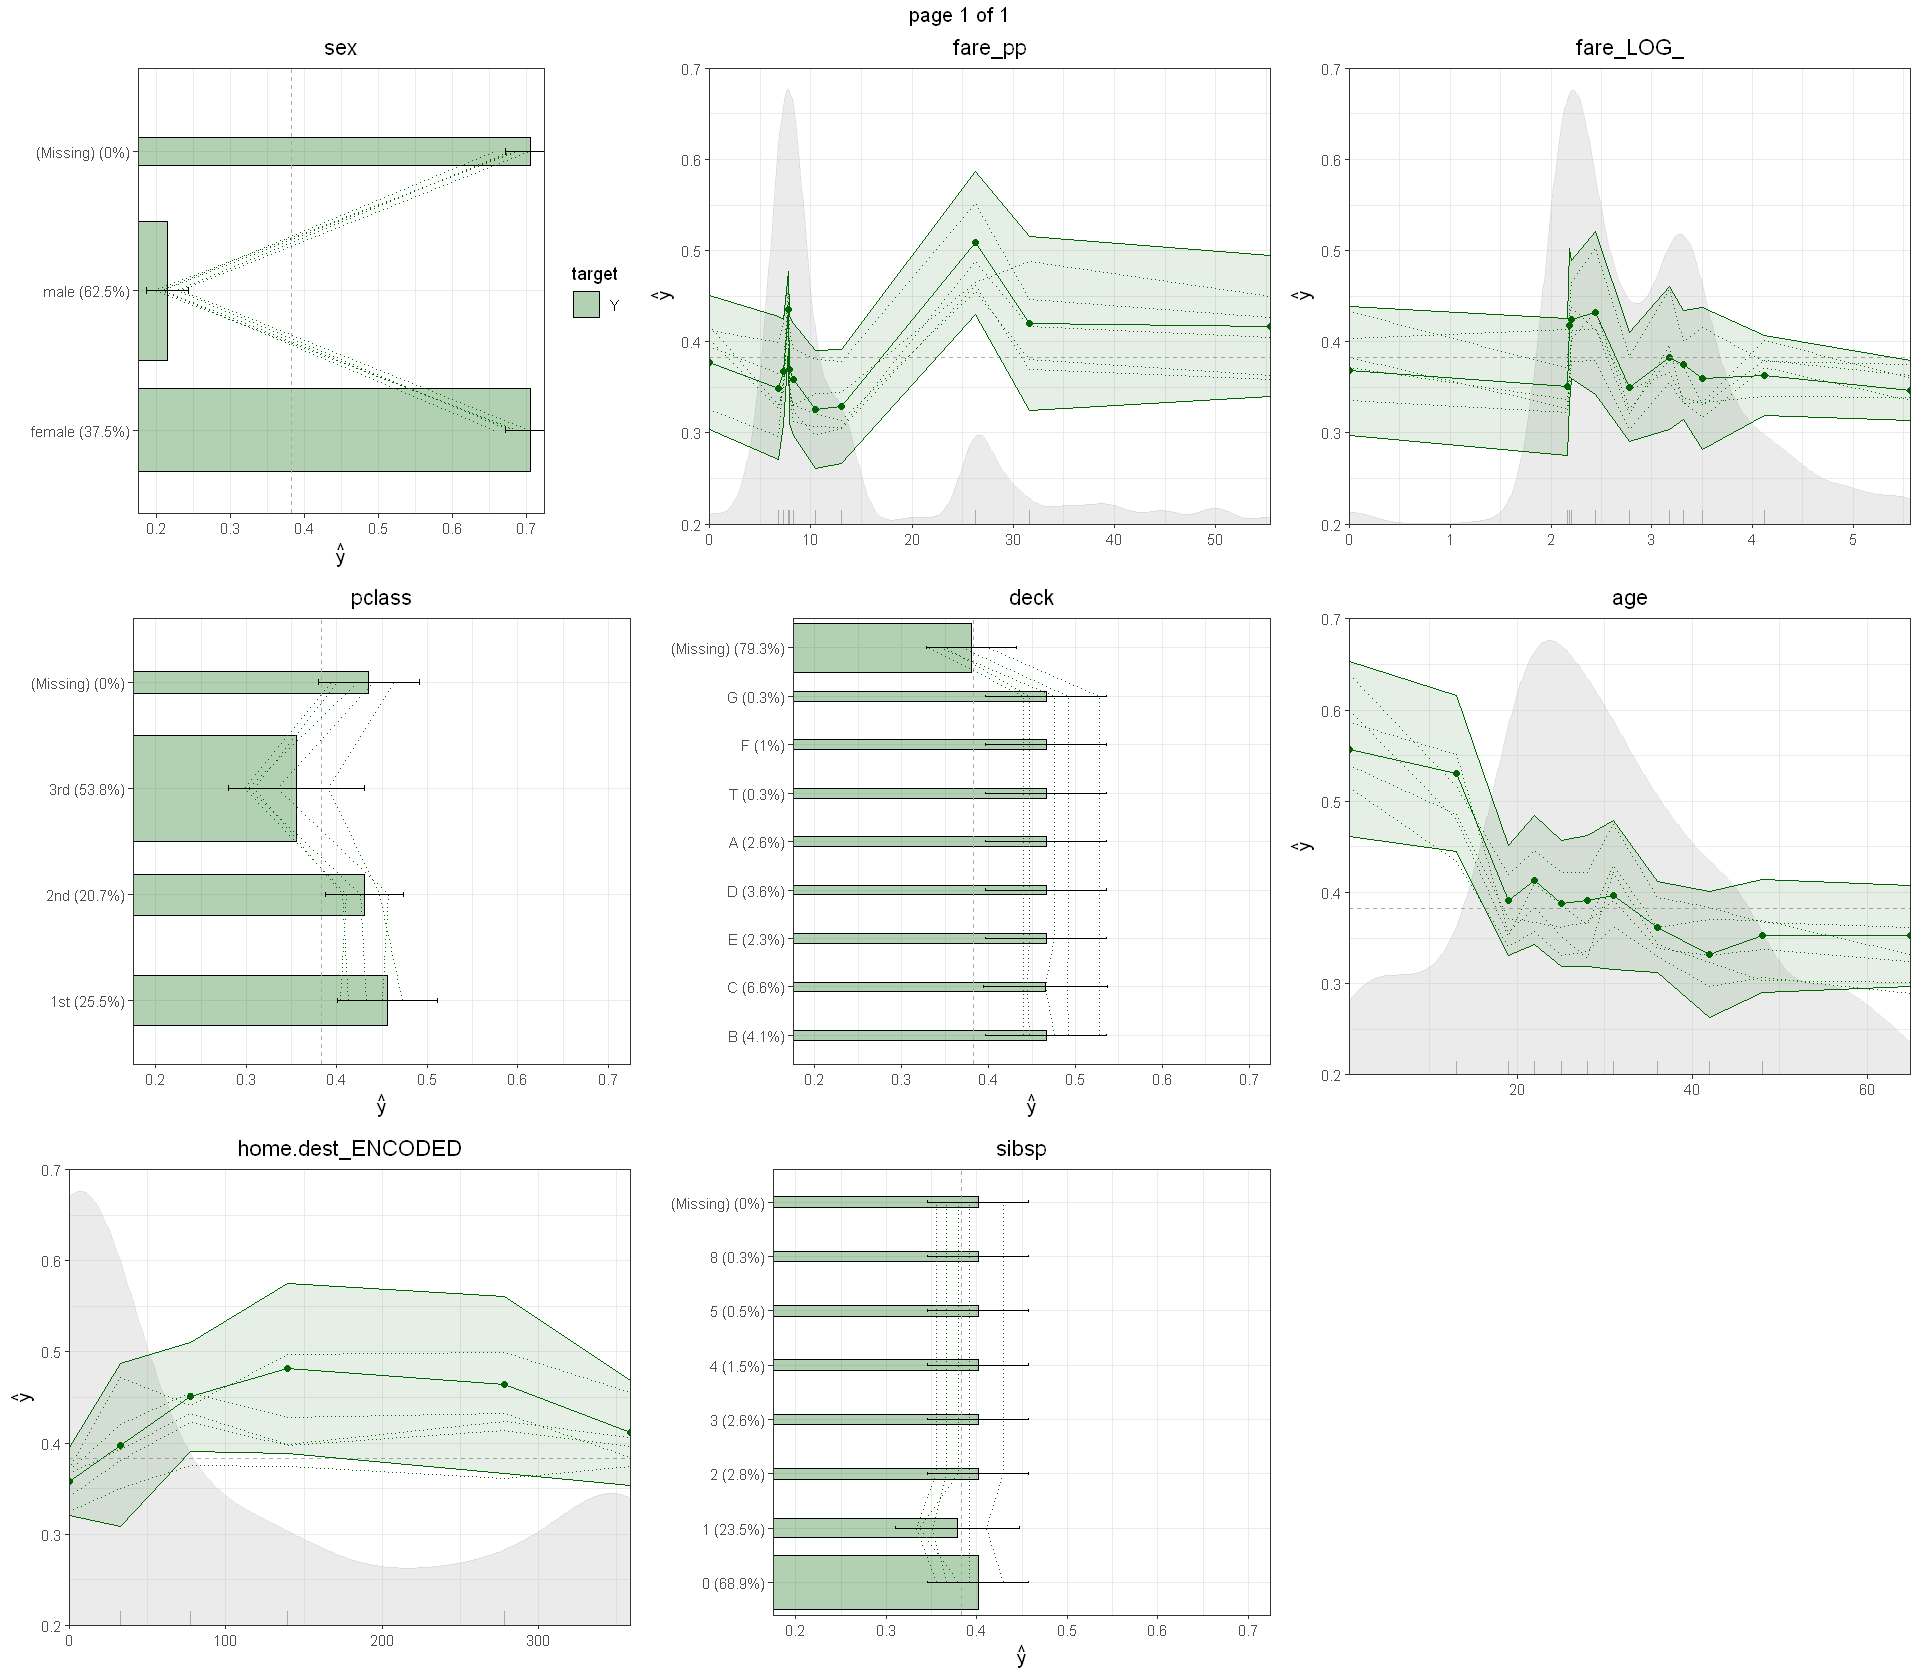

In [14]:
## Partial depdendance for "total" fit
df.partialdep = hmsPM::calc_partial_dependencies(df_data        = df.test,
                                                 df_data_orig   = df.test,
                                                 fit            = fit,
                                                 formula_string = formula,
                                                 sparse         = TRUE,
                                                 feature_names  = topn_features,
                                                 b_sample = b_sample, b_all = b_all)



## Partial dependance cv models
# Get crossvalidated values
df.partialdep_cv = c()
for (i in 1:length(l.test)) {
  df.partialdep_cv %<>%
    bind_rows(hmsPM::calc_partial_dependencies(df_data        = df[l.test[[i]],],
                                               df_data_orig   = df.test,
                                               fit            = l.fits[[i]],
                                               formula_string = formula, sparse = TRUE,
                                               feature_names  = topn_features,
                                               b_sample = l.b_sample[[i]], b_all = l.b_all[[i]]) %>%
                mutate(run = i))
}


## Plot
plots = suppressWarnings(suppressMessages(
  hmsPM::plot_all_partial_dependencies(df_partialdep    = df.partialdep,
                                       df_data          = df.test,
                                       feature_names    = topn_features,
                                       df_partialdep_cv = df.partialdep_cv,
                                       ylim             = c(0.2,0.7),
                                       colors           = twocol,
                                       add_cv_lines     = TRUE,
                                       add_cv_conf_int  = TRUE,
                                       verbose          = FALSE)))
options(repr.plot.width = 16, repr.plot.height = 14) #adapt this for different resolution
marrangeGrob(suppressMessages(plots), ncol = 3, nrow = 3) #arrange plots


We can see that *sex* reveals a similar effect as in the univariate plot of *1_explore_R.ipynb*. But e.g. for *pclass* this changes which one would ususally expect as here a multivariate model is applied (compared to the univariate effects in the exploration part).  
A little weird looks the *fare_pp* effect, it seems that it mixes up a little with the *pclass* to which it is correlated (see next plot).

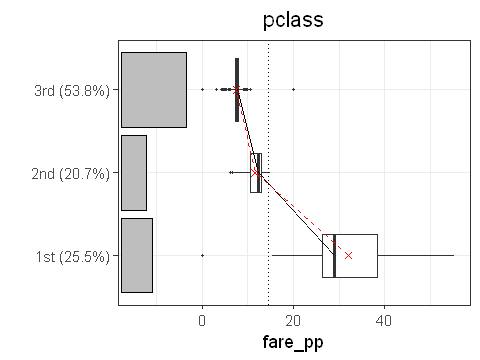

In [15]:
options(repr.plot.width = 4, repr.plot.height = 3)
plot_distr(df.test$pclass,df.test$fare_pp, "pclass", "fare_pp", verbose = FALSE)

<br><br>
## 5 Some explanations
We finally plot some more explanations of the 3 highest, 3 lowest and 4 sampled records (see also chapter 2.2 above).  
Be aware that these kind of plots can be presented for any prediction provided to business and fully explains how the predictions is received which can help in **deciding for actions resulting from the prediction**.


 Predictions and explanations match 


[[1]]
NULL


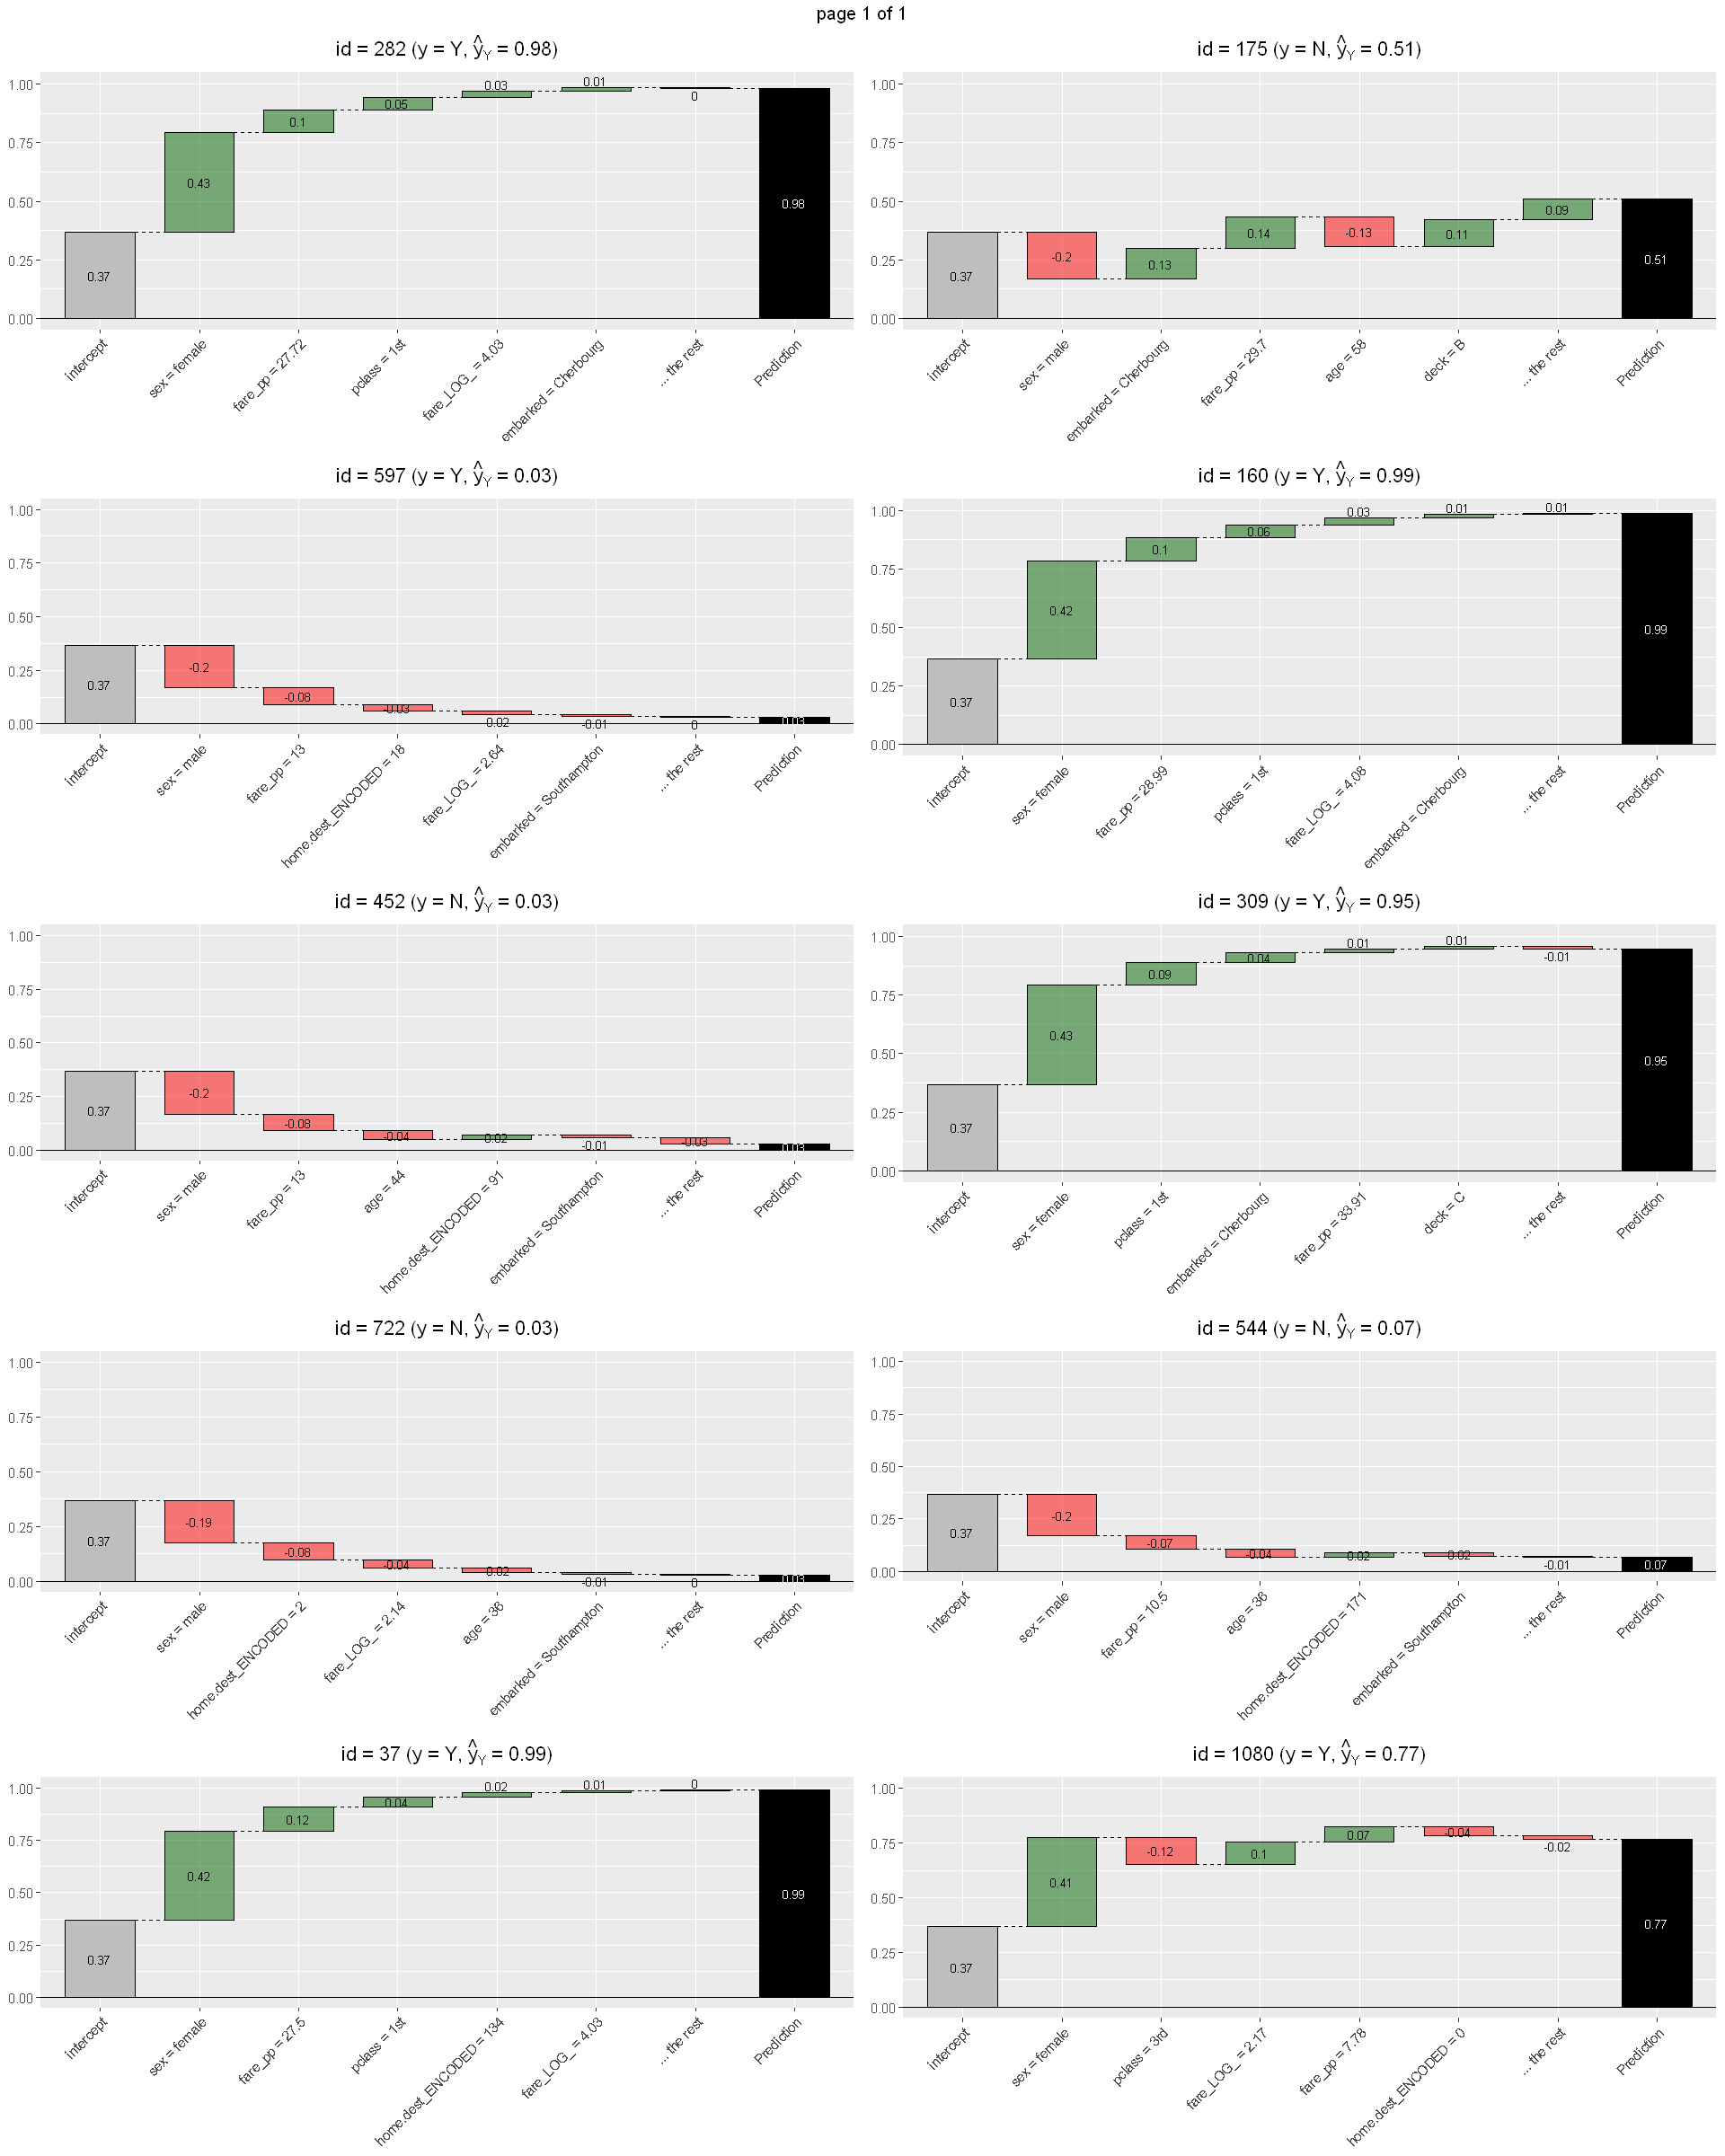

In [16]:
## Subset test data (explanations are only calculated for this subset)
i.top = order(df.test$yhat, decreasing = TRUE)[1:3]
i.bottom = order(df.test$yhat)[1:3]
i.random = sample(1:length(df.test$yhat), 4)
i.explain = sample(unique(c(i.top, i.bottom, i.random)))
df.test_explain = df.test[i.explain,]
yhat_explain = predict(fit, 
                       sparse.model.matrix(as.formula(formula), df.test_explain[c("target",features)]), 
                       type = "prob") %>%
  hmsPM::scale_predictions(b_sample, b_all)


## Get explanations
df.weights = hmsPM::calc_xgb_weights(fit            = fit,
                                     formula_string = formula, sparse = TRUE,
                                     df_test        = df.test_explain,
                                     yhat           = yhat_explain,
                                     df_explainer   = df.explainer,
                                     b_sample = b_sample, b_all = b_all,
                                     id_name        = "id",
                                     top_n          = 5)


## Plot
plots = hmsPM::plot_all_xgb_explanations(df_explanations = df.weights,
                                         id_name         = "id",
                                         ylim            = c(0,1),
                                         colors          = alpha(twocol,0.5),
                                         verbose         = FALSE)
options(repr.plot.width = 16, repr.plot.height = 20) #adapt this for different resolution
marrangeGrob(suppressMessages(plots), ncol = 2, nrow = 5) #arrange plots

<br><br>
## 5 Individual Dependencies
We finalize our interpretation part by plotting also the "individual dependencies" for one id. This plot shows how a prediction of an individual would change if the feature values would change. In fact the partial dependence plot above is an avearge of all individual dependencies.  
In the plot you can identify the current value (and prediction) by the black border or dot.

[[1]]
NULL


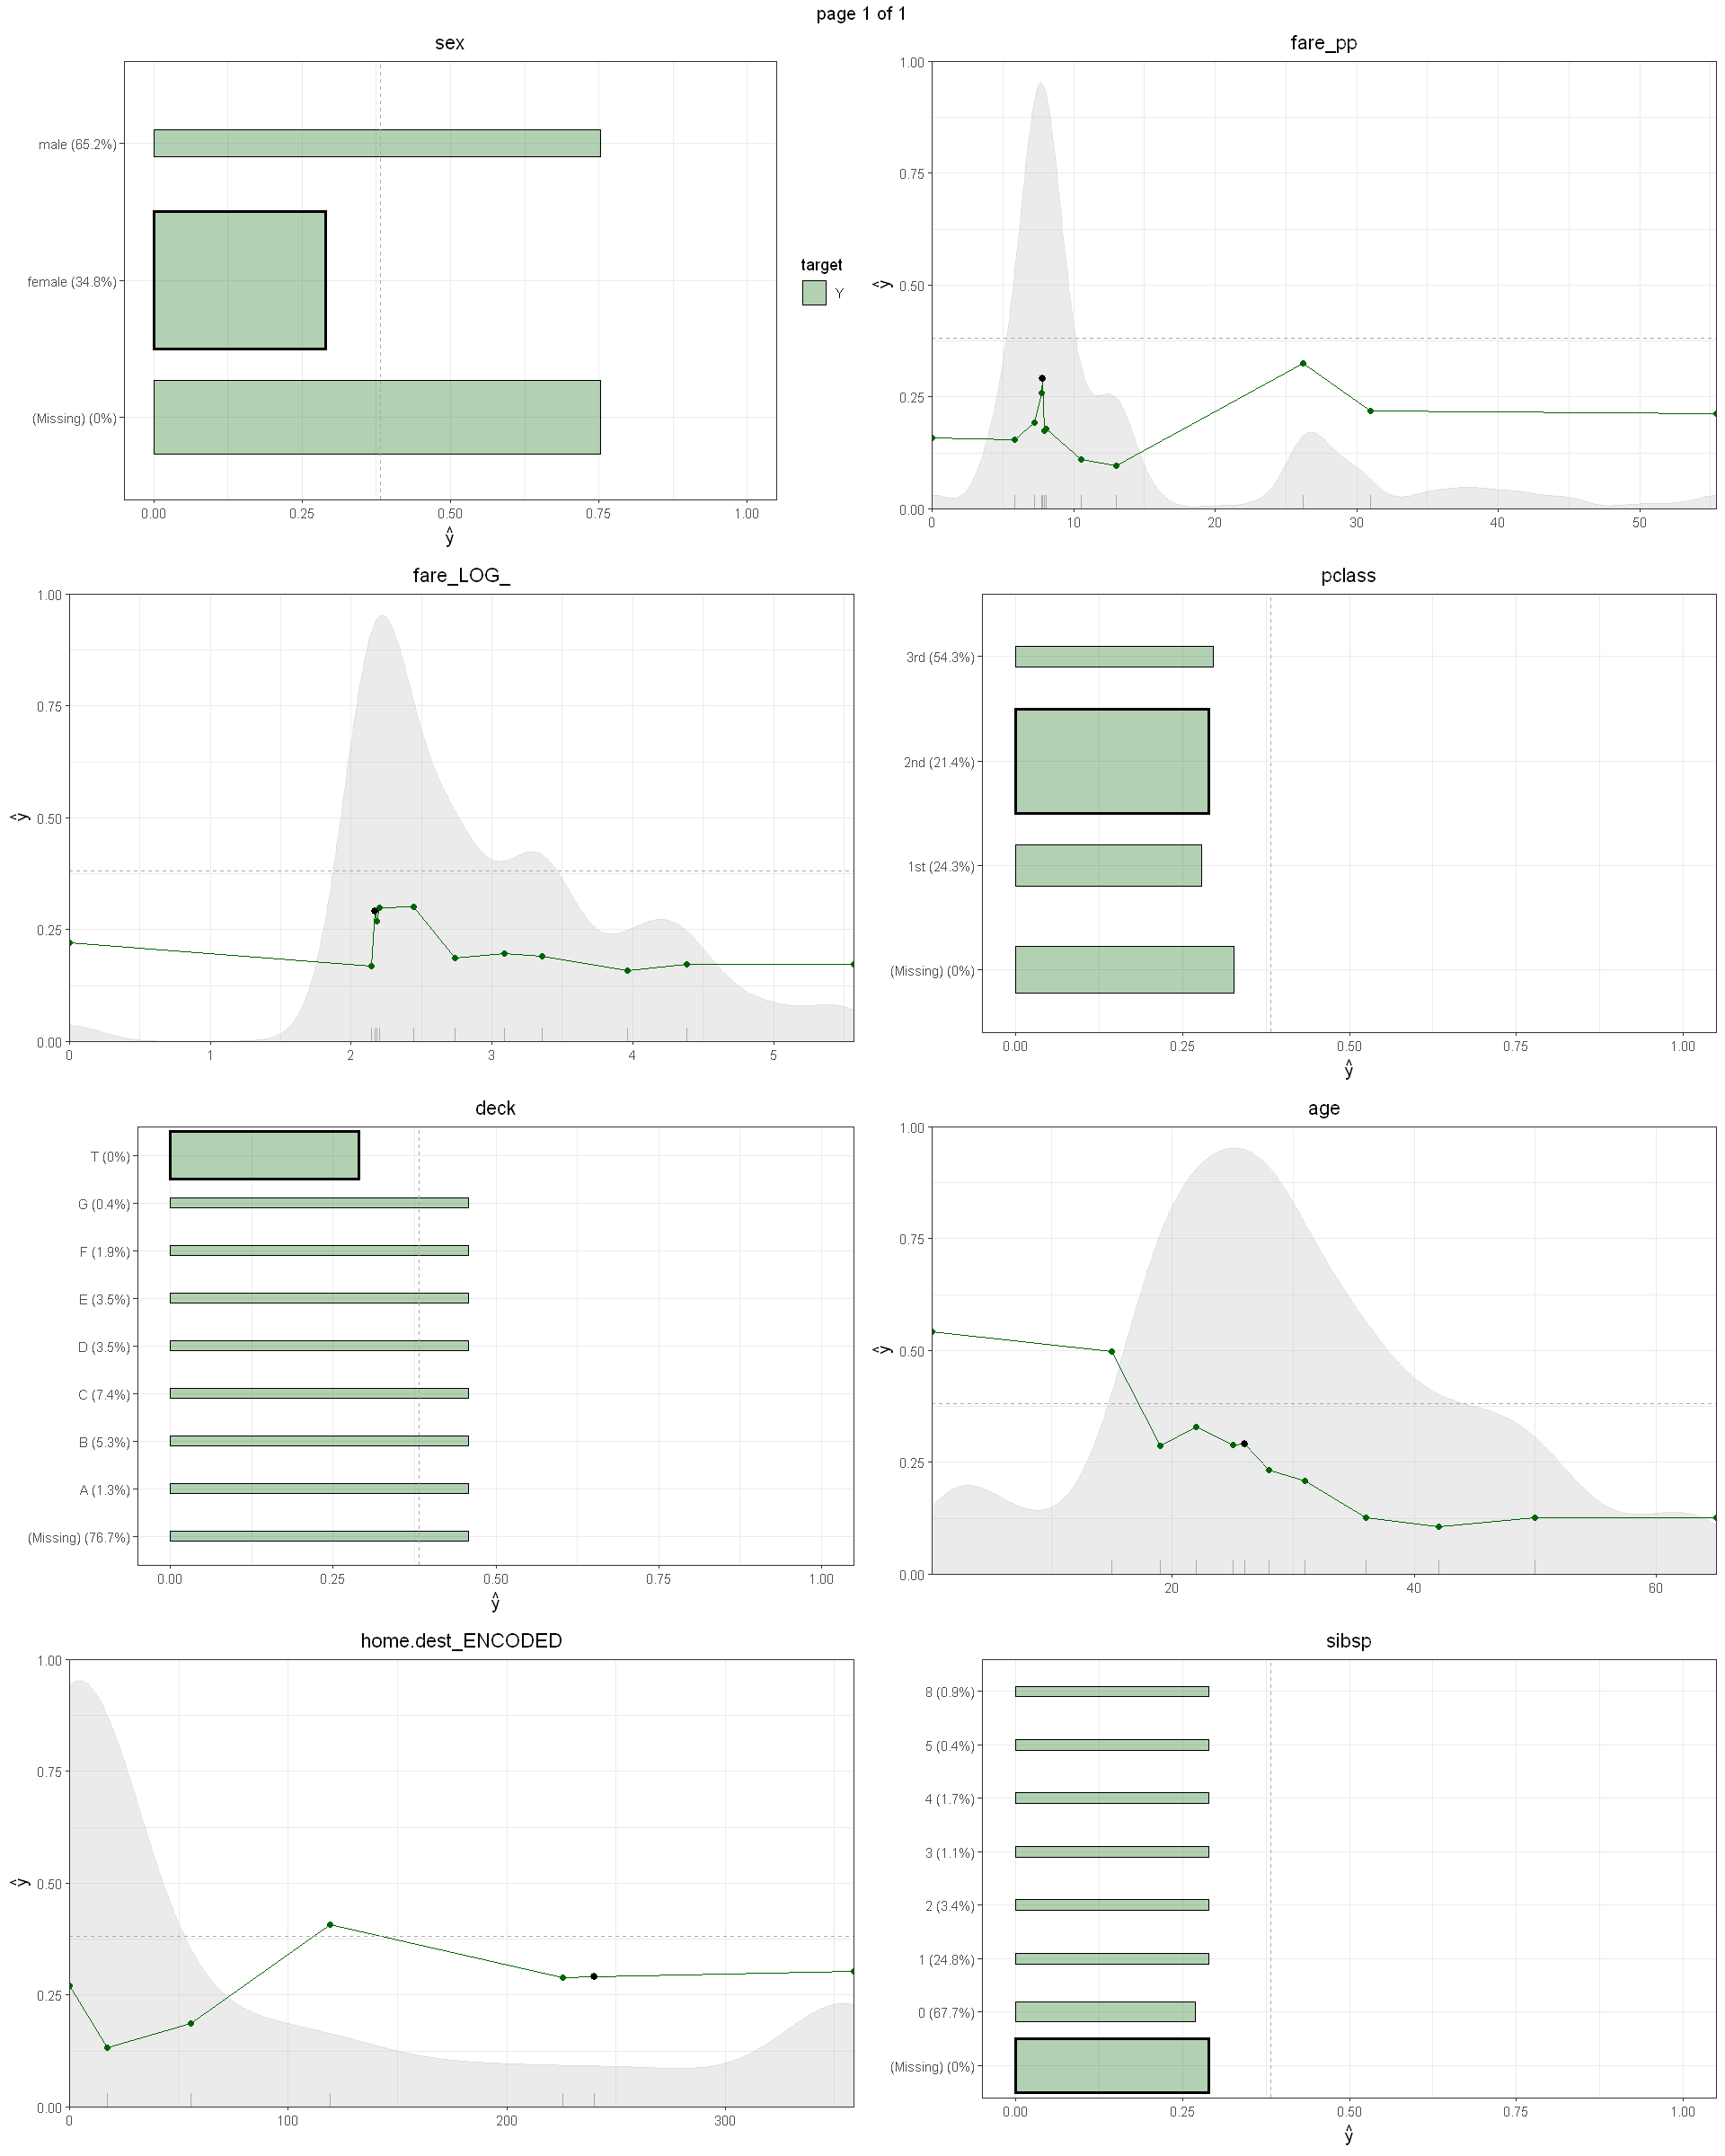

In [17]:
set.seed(123)
ids = sample(unique(df.test[["id"]]), 10)
df.indidep = hmsPM::calc_individual_dependencies(df_data        = df.test %>% filter(.data[["id"]] %in% ids),
                                                 df_data_orig   = df %>% filter(fold == "train"),
                                                 fit            = fit,
                                                 formula_string = formula, sparse = TRUE,
                                                 feature_names  = topn_features,
                                                 b_sample = b_sample, b_all = b_all,
                                                 id_name        = "id")
id_select = ids[3]
plots = hmsPM::plot_all_individual_dependencies(df_individualdep     = df.indidep %>%
                                                  filter(.data[["id"]] == id_select),
                                                df_data              = df %>% filter(fold == "train"),
                                                feature_names        = topn_features,
                                                individual_flag_name = "orig_data_flag",
                                                ylim                 = c(0,1),
                                                colors               = twocol,
                                                verbose              = FALSE)
options(repr.plot.width = 16, repr.plot.height = 20) #adapt this for different resolution
marrangeGrob(suppressMessages(plots), ncol = 2, nrow = 4) #arrange plots

<br><br>  
We finished the interpretation part of our modeling. The pupose was to get evaluate the predictive performance by more means than just the AUC metric, investigate false predictions the model is creating, interpret the importance and influence of all features on a global but also individual record level. All this might be an iterative process till we reached enough confidence in the final model. Once this is done we can start to build the productive training and scoring code (see forthcoming notebooks).